In [1]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection 

model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load model directly
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny").to(device)
image_url = "frame.jpg"
image = Image.open(image_url)
# Check for cats and remote controls
# VERY important: text queries lneed to be lowercased + end with a dot



/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-24 12:23:57.088022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 12:23:57.103720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 12:23:57.108328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 12:23:57.119784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use av

In [13]:
text = "face. text."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)



[{'scores': tensor([0.7487, 0.5982], device='cuda:0'), 'labels': ['face', 'text'], 'boxes': tensor([[308.4547, 160.4042, 605.3057, 569.4574],
        [231.4654, 645.4247, 489.2487, 711.9968]], device='cuda:0')}]
tensor([308.4547, 160.4042, 605.3057, 569.4574], device='cuda:0')
308.45474 160.4042 296.85092 409.0532
tensor([231.4654, 645.4247, 489.2487, 711.9968], device='cuda:0')
231.46536 645.42474 257.7833 66.57208


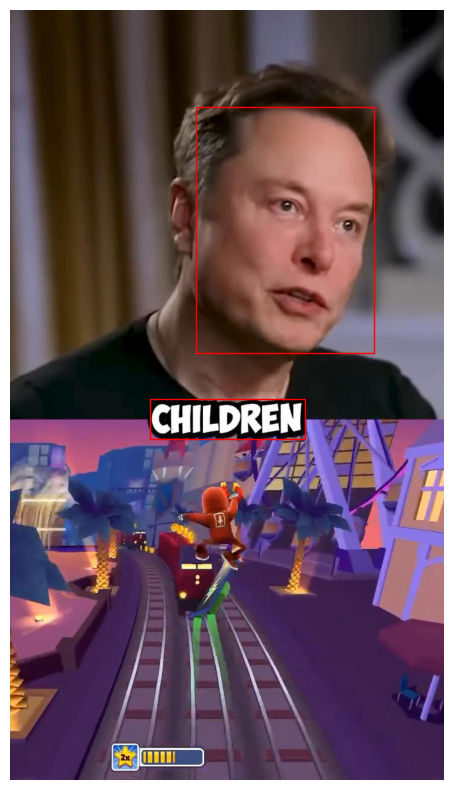

In [14]:
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.4,
    target_sizes=[image.size[::-1]]
)
#Show image with bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
print(results)
for result in results:
    i = 0
    for box in result["boxes"]:
        print(box)
        x1, y1, x2, y2 = box
        x1 = x1.cpu().numpy()
        y1 = y1.cpu().numpy()
        x2 = x2.cpu().numpy()
        y2 = y2.cpu().numpy()
        
        x, y, w, h = x1, y1, x2 - x1, y2 - y1
        print(x, y, w, h)

        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        


plt.axis("off")
plt.show()

In [3]:
from PIL import Image
from presidio_image_redactor import ImageRedactorEngine

# Get the image to redact using PIL lib (pillow)
image = Image.open("frame.jpg")

# Initialize the engine
engine = ImageRedactorEngine()

# Redact the image with pink color
redacted_image = engine.redact(image, (255, 192, 203))

# save the redacted image 
redacted_image.save("new_image.png")
# uncomment to open the image for viewing
# redacted_image.show()

In [1]:
!nvidia-smi

Tue Sep 24 13:17:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:2B:00.0  On |                  N/A |
|  0%   40C    P8             10W /  165W |     416MiB /  16380MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("lakshyakh93/deberta_finetuned_pii")
model = AutoModelForTokenClassification.from_pretrained("lakshyakh93/deberta_finetuned_pii")

In [19]:
id2label = model.config.id2label
label2id = {v: k for k, v in id2label.items()}

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def mask_pii(text, aggregate_redaction=True):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted labels
    predictions = torch.argmax(outputs.logits, dim=-1)

    # Convert token predictions to word predictions
    encoded_inputs = tokenizer.encode_plus(text, return_offsets_mapping=True, add_special_tokens=True)
    offset_mapping = encoded_inputs['offset_mapping']

    masked_text = list(text)
    is_redacting = False
    redaction_start = 0
    current_pii_type = ''

    for i, (start, end) in enumerate(offset_mapping):
        if start == end:  # Special token
            continue

        label = predictions[0][i].item()
        if label != label2id['O']:  # Non-O label
            pii_type = id2label[label]
            if not is_redacting:
                is_redacting = True
                redaction_start = start
                current_pii_type = pii_type
            elif not aggregate_redaction and pii_type != current_pii_type:
                # End current redaction and start a new one
                apply_redaction_scramble(masked_text, redaction_start, start, current_pii_type, aggregate_redaction)
                redaction_start = start
                current_pii_type = pii_type
        else:
            if is_redacting:
                apply_redaction_scramble(masked_text, redaction_start, end, current_pii_type, aggregate_redaction)
                is_redacting = False

    # Handle case where PII is at the end of the text
    if is_redacting:
        apply_redaction_scramble(masked_text, redaction_start, len(masked_text), current_pii_type, aggregate_redaction)

    return ''.join(masked_text)

def apply_redaction_scramble(masked_text, start, end, pii_type, aggregate_redaction):
    for j in range(start, end):
        masked_text[j] = ''
    if aggregate_redaction:
        masked_text[start] = '[redacted]'
    else:
        masked_text[start] = f'[{pii_type}]'


In [20]:
example_text = "Arnesh Batra"

print("Aggregated redaction:")
masked_example_aggregated = mask_pii(example_text, aggregate_redaction=True)
print(masked_example_aggregated)

print("\nDetailed redaction:")
masked_example_detailed = mask_pii(example_text, aggregate_redaction=False)
print(masked_example_detailed)

Aggregated redaction:
[redacted]

Detailed redaction:
[B-FULLNAME][I-FULLNAME]


In [7]:
#Get redacted names
import re
import spacy

og_sen = "My name is Obee Nobi and I live at 432423 Deka St, Tanooti. My phone number is 54551234567."
redacted = "My name is [redacted] I live at [redacted] [redacted]i. My phone number is [redacted]4567."

names = list(set(og_sen.split(" ")) - set(redacted.split(" ")))
names

['432423', 'Obee', 'and', 'Deka', 'Nobi', 'St,', '54551234567.', 'Tanooti.']

In [25]:
#Get redacted words
import re
example_text = "My name is Obee Nobi and I live at 432423 Deka St, Tanooti. My phone number is 54551234567."
redacted = "My name is [redacted] I live at [redacted] [redacted]i. My phone number is [redacted]4567."

#Get dictionary of redacted words

def get_redacted_words(text, redacted):
    redacted_words = {}
    for word in text.split():
        if word not in redacted.split():
            redacted_words[word] = "[redacted]"
    return redacted_words

redacted_words = get_redacted_words(example_text, redacted)
print(redacted_words)


{'Obee': '[redacted]', 'Nobi': '[redacted]', 'and': '[redacted]', '432423': '[redacted]', 'Deka': '[redacted]', 'St,': '[redacted]', 'Tanooti.': '[redacted]', '54551234567.': '[redacted]'}


In [27]:

# pip install git+https://github.com/huggingface/transformers.git
# pip install accelerate
# pip install torch

from transformers import pipeline

text_generator = pipeline("text-generation", model="anezatra/chat-gpt2", tokenizer="anezatra/chat-gpt2")

prompt = "Randome Person NAME:"

generated_text = text_generator(prompt, max_length=10, num_return_sequences=1)

print(generated_text[0]["generated_text"])


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Randome Person NAME: Alexander H. Mitchell,


In [1]:
from llama_cpp import Llama

llm = Llama.from_pretrained(
	repo_id="Qwen/Qwen2-0.5B-Instruct-GGUF",
	filename="qwen2-0_5b-instruct-fp16.gguf",
)

llm.create_chat_completion(
	messages = [
		{
			"role": "user",
			"content": "What is the capital of France?"
		}
	]
)

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
llama_model_loader: loaded meta data with 22 key-value pairs and 290 tensors from /home/arnesh/.cache/huggingface/hub/models--Qwen--Qwen2-0.5B-Instruct-GGUF/snapshots/198f08841147e5196a6a69bd0053690fb1fd3857/./qwen2-0_5b-instruct-fp16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.name str              = qwen2-0_5b-instruct
llama_model_loader: - kv   2:                          qwen2.block_count u32              = 24
llama_model_loader: - kv   3:                       qwen2.context_length u32              =

In [4]:

output = llm.create_chat_completion(
    messages = [
        {
            "role": "user",
            "content": "What is the capital of France?"
        }
    ]
) 
print(output)
response = output['choices'][0]['message']["content"]
print(response)

Llama.generate: 25 prefix-match hit, remaining 1 prompt tokens to eval

llama_print_timings:        load time =      70.47 ms
llama_print_timings:      sample time =       0.57 ms /     8 runs   (    0.07 ms per token, 13986.01 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =     212.94 ms /     8 runs   (   26.62 ms per token,    37.57 tokens per second)
llama_print_timings:       total time =     216.67 ms /     8 tokens


{'id': 'chatcmpl-c3cb2a5f-e072-4607-a7e4-ea1e3a0cbbe6', 'object': 'chat.completion', 'created': 1727121846, 'model': '/home/arnesh/.cache/huggingface/hub/models--Qwen--Qwen2-0.5B-Instruct-GGUF/snapshots/198f08841147e5196a6a69bd0053690fb1fd3857/./qwen2-0_5b-instruct-fp16.gguf', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'The capital of France is Paris.'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 26, 'completion_tokens': 7, 'total_tokens': 33}}
The capital of France is Paris.


In [1]:
!nvidia-smi

Tue Sep 24 15:39:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:2B:00.0  On |                  N/A |
|  0%   43C    P8              9W /  165W |    3168MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from deepface import DeepFace

backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'fastmtcnn',
  'retinaface', 
  'mediapipe',
  'yolov8',
  'yunet',
  'centerface',
]

alignment_modes = [True, False]

face_objs = DeepFace.extract_faces(
  img_path = "frame.jpg", 
  detector_backend = backends[0],
  align = alignment_modes[0],
)

2024-09-24 15:57:26.559539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 15:57:26.574471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 15:57:26.579059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 15:57:26.590418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 15:57:27.303119: W tensorflow/compiler/tf2

In [2]:
face_objs
x,y,w,h = face_objs[0]["facial_area"]['x'], face_objs[0]["facial_area"]['y'], face_objs[0]["facial_area"]['w'], face_objs[0]["facial_area"]['h']
print(x,y,w,h)


339 199 339 339


In [9]:
video_path = "demo.mp4"
#Export bounding boxes video
import cv2
import numpy as np

cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

#Check fps
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        try:
            obsj = DeepFace.extract_faces(
                img_path = frame, 
                detector_backend = backends[7],
                align = alignment_modes[0],
                
            )

            for obj in obsj:    
                x,y,w,h = obj["facial_area"]['x'], obj["facial_area"]['y'], obj["facial_area"]['w'], obj["facial_area"]['h']
                cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        except Exception as e:
            print (e)
            pass
        out.write(frame)
    else:
        break



25.0
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/arnesh/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
24-09-24 16:08:53 - 🔗 yolov8n-face.pt will be downloaded from https://drive.google.com/uc?id=1qcr9DbgsX3ryrz2uU8w4Xm3cOrRywXqb to /home/arnesh/.deepface/weights/yolov8n-face.pt...


Downloading...
From: https://drive.google.com/uc?id=1qcr9DbgsX3ryrz2uU8w4Xm3cOrRywXqb
To: /home/arnesh/.deepface/weights/yolov8n-face.pt
100%|██████████| 6.39M/6.39M [00:00<00:00, 9.98MB/s]


In [42]:
from transformers import pipeline
pipe = pipeline("token-classification", model="Isotonic/deberta-v3-base_finetuned_ai4privacy_v2")   
text = "My name is John and I live in California."
output = pipe(text, aggregation_strategy="first")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [43]:
output

[{'entity_group': 'FIRSTNAME',
  'score': 0.98988885,
  'word': 'John',
  'start': 10,
  'end': 15},
 {'entity_group': 'STATE',
  'score': 0.9936884,
  'word': 'California.',
  'start': 29,
  'end': 41}]

In [17]:
text = "Batra"
output = gen(text, aggregation_strategy="first")
output

[{'entity_group': 'FIRSTNAME',
  'score': 0.9992126,
  'word': ' Batra',
  'start': 0,
  'end': 5}]

In [24]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

In [29]:
raw_text="My name is John and I live in California."
text1= NER(raw_text)

for word in text1.ents:
    print(word.text,word.label_)

John PERSON
California GPE


In [1]:
import winreg

key = winreg.OpenKey(winreg.HKEY_LOCAL_MACHINE, r"SYSTEM\\CurrentControlSet\\Control\\FileSystem", 0, winreg.KEY_WRITE)
winreg.SetValueEx(key, "LongPathsEnabled", 0, winreg.REG_DWORD, 1)
winreg.CloseKey(key)

PermissionError: [WinError 5] Access is denied